### Detectors, descriptors, and image segmentation using python



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import cv2 
from skimage.feature import corner_harris, corner_peaks

# This code is to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
def displayImage(img):
    # Show image
    plt.figure(figsize = (10,7))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    
def readImage(imagePath):
    # Your code here
    return mpimg.imread(imagePath)

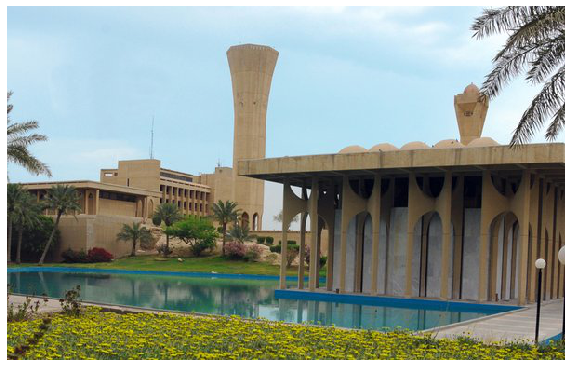

(380, 600, 3)


In [3]:
image = readImage("image1.jpg")

displayImage(image)

print(image.shape)

## Question 01 [Detector] 
In this part, you will implement a Harris detector to detect keypoints as follows:

1. Create a python function harris_detector that gets an image as input and returns the response (R) which is computed as follows:
    
    (a) Compute the structure tensor matrix (M)


![Picture1.jpg](attachment:Picture1.jpg)

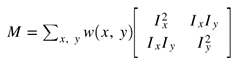

        You can use a Gaussian window W of size 3x3.
     
    (b) For each pixel, compute the corner response R=Det(M)-k(Trace(M)2)


2. Pass image1.jpg to harris_detector function and display the detected corners on this image.

3. Use the corner_peaks method in skimage.feature to find peaks in the corner measure response image (R).

In [4]:
# Your code here
def harris_detector(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    displayImage(gray)
    gray = np.float32(gray)
    sobelx = cv2.Sobel(gray,cv2.cv2.CV_32F,1,0,ksize=3)  # x
    sobely = cv2.Sobel(gray,cv2.cv2.CV_32F,0,1,ksize=3)  # y

    dx2 = np.square(sobelx)
    dy2 = np.square(sobely)
    dxdy = sobelx*sobely

    g_dx2 = cv2.GaussianBlur(dx2,(3,3),1)
    g_dy2 = cv2.GaussianBlur(dy2,(3,3),1)
    g_dxdy = cv2.GaussianBlur(dxdy,(3,3),1)


    # R=Det(M)-k(Trace(M)2)
    harris = g_dx2*g_dy2 - np.square(g_dxdy) - 0.04*np.square(g_dx2 + g_dy2) 
    
    return harris

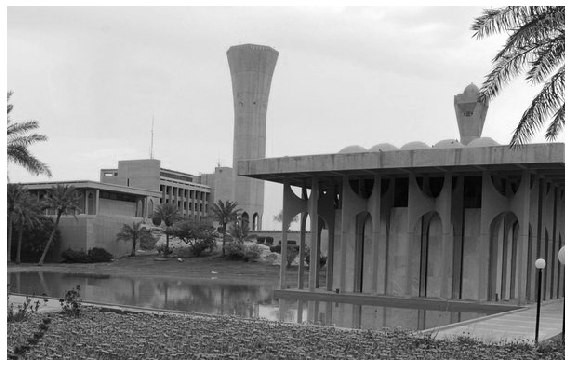

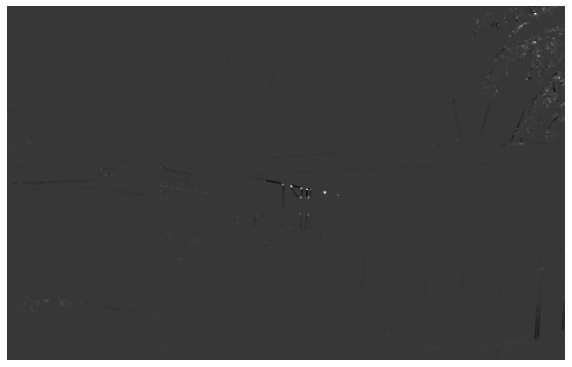

(380, 600)


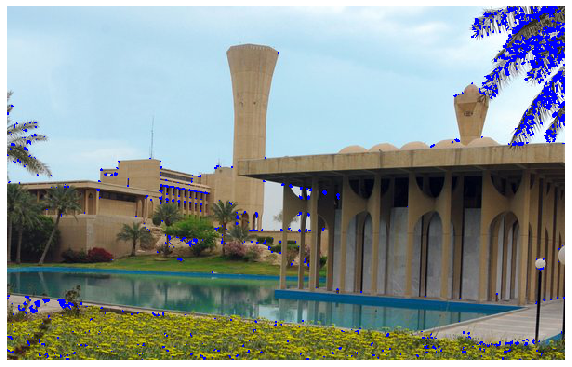

In [5]:
image = readImage("image1.jpg")
R = harris_detector(image)
displayImage(R)
print(R.shape)

image[R>0.01*R.max()]=[0,0,255]
displayImage(image)

### Verifying using API

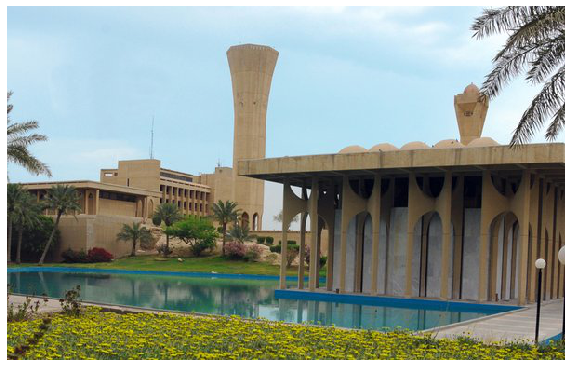

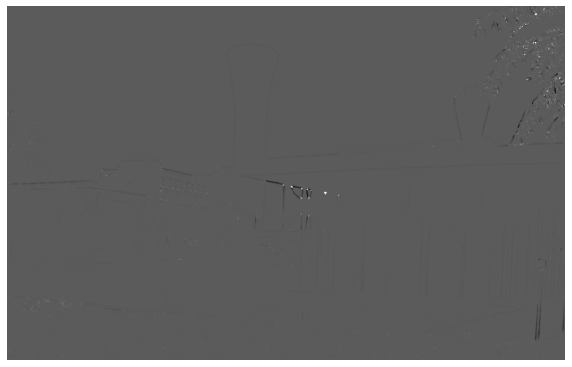

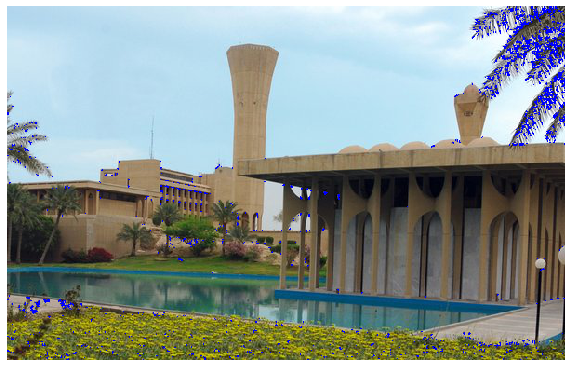

(380, 600)


In [6]:

def harris_detector_cv(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    # Threshold for an optimal value, it may vary depending on the image.
    return dst
image = readImage("image1.jpg")
displayImage(image)
R = harris_detector_cv(image)
displayImage(R)
image[R>0.01*R.max()]=[0,0,255]
displayImage(image)
print(R.shape)

## Question 02 [SIFT] 

Use SIFT for matching the keypoints between image1 and image2. Please follow these steps:

1. Detect keypoints.

2. Describe detected keypoints.

3. Perform matching between keypoints descriptors using KNN and keep only matches with small distances.

4. Draw the matched keypoints.


In [12]:
def sift(img1,img2):
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.6*n.distance:
            matchesMask[i]=[1,0]
    draw_params = dict(matchColor = (0,0,255),
                    singlePointColor = (255,0,0),
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
    return img3

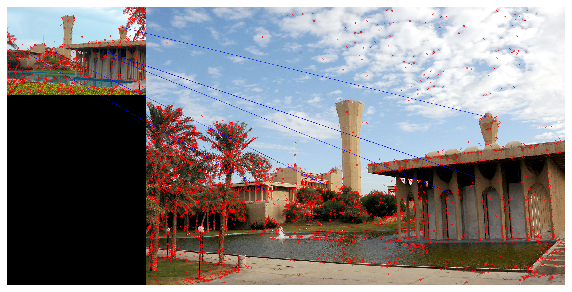

In [13]:
image1 = readImage('image1.jpg')
image2 = readImage('image2.jpg')

res = sift(image1, image2)
displayImage(res)

## Question 03 [Segmentation] 

1. Use K-means clustering for clustering road.jpg and Office-4.jpg images. Use a different number of clusters until you reach a reasonable solution. Analyze the results of applying the different cluster numbers?


2. Use mean-shift clustering for clustering road.jpg and Office-4.jpg images. Use different window sizes. Analyze the results of applying different window sizes? Compare results with k-means?

In [14]:
# Your code here
def k_mean(img, k):

    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = k
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))


    return res2

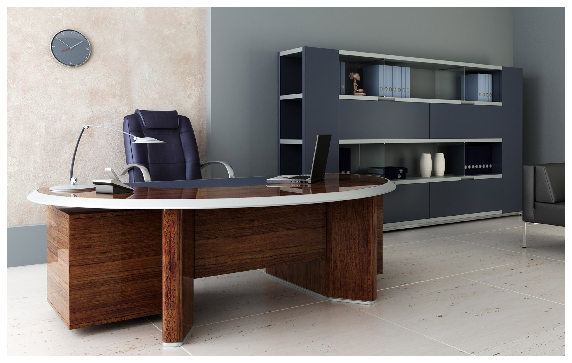

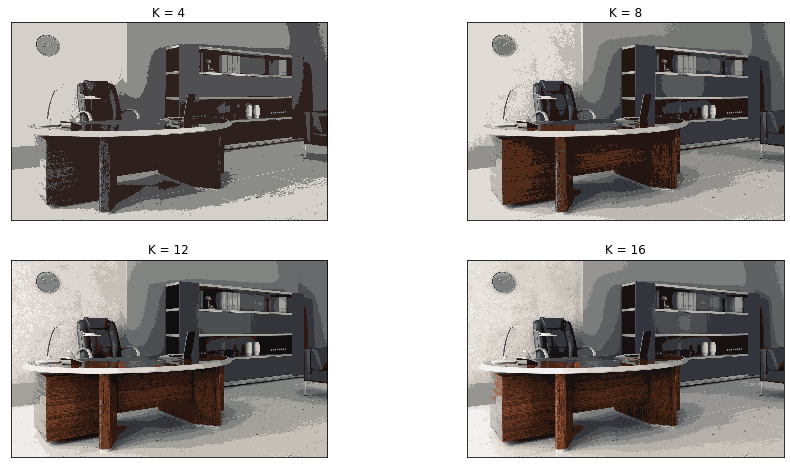

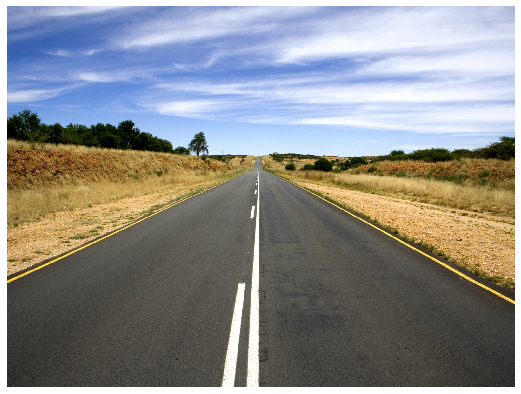

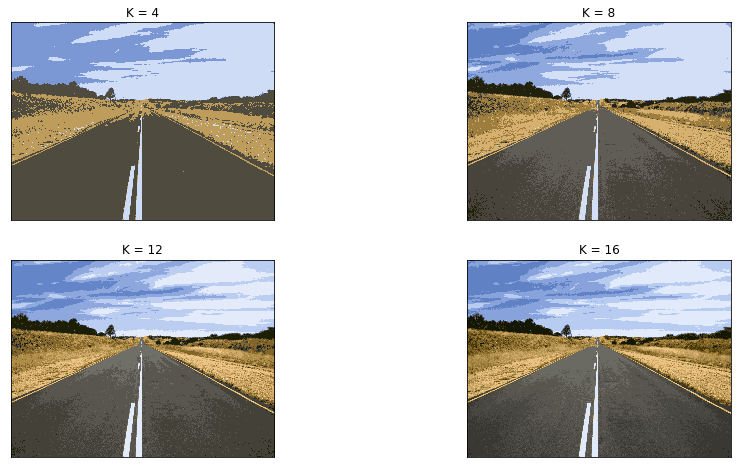

In [15]:
image1 = readImage('Office-4.jpg')
image2 = readImage('road.jpg')

img1 = k_mean(image1,4)
img2 = k_mean(image1,8)
img3 = k_mean(image1,12)
img4 = k_mean(image1,16)

img2_1 = k_mean(image2,4)
img2_2 = k_mean(image2,8)
img2_3 = k_mean(image2,12)
img2_4 = k_mean(image2,16)


displayImage(image1)
plt.subplot(2,2,1),plt.imshow(img1)
plt.title('K = 4'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(img2)
plt.title('K = 8'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(img3)
plt.title('K = 12'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(img4)
plt.title('K = 16'), plt.xticks([]), plt.yticks([])
plt.show()

displayImage(image2)
plt.subplot(2,2,1),plt.imshow(img2_1)
plt.title('K = 4'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(img2_2)
plt.title('K = 8'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(img2_3)
plt.title('K = 12'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(img2_4)
plt.title('K = 16'), plt.xticks([]), plt.yticks([])

plt.show()

In [16]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift(img):
    # filter to reduce noise
    img = cv2.medianBlur(img, 3)

    # flatten the image
    flat_image = img.reshape((-1,3))
    flat_image = np.float32(flat_image)

    # meanshift
    bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
    ms = MeanShift(bandwidth, max_iter=800, bin_seeding=True)
    ms.fit(flat_image)
    labeled=ms.labels_


    # get number of segments
    segments = np.unique(labeled)
    print('Number of segments: ', segments.shape[0])

    # get the average color of each segment
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    avg = total/count
    avg = np.uint8(avg)

    # cast the labeled image into the corresponding average color
    res = avg[labeled]
    result = res.reshape((img.shape))
    return result

C:\Users\omar\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=19.365154383222205 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of segments:  8


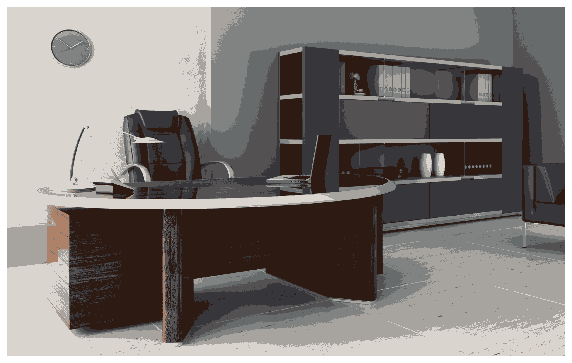

C:\Users\omar\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=23.362005789071514 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of segments:  9


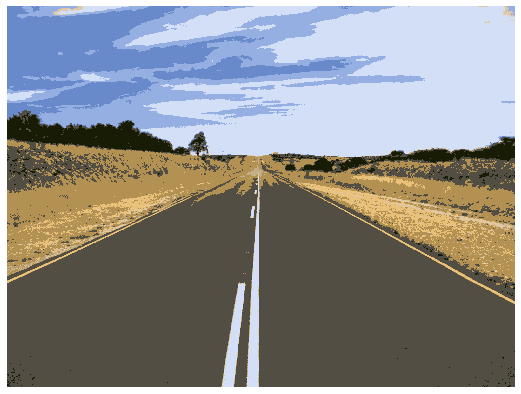

In [17]:
image1 = readImage('Office-4.jpg')
image2 = readImage('road.jpg')

result1 = mean_shift(image1)
displayImage(result1)
result2 = mean_shift(image2)
displayImage(result2)